<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# 1. Problem Statement and Data Collection

---

## 1.1 Background

In Singapore, the aspiration for achieving early retirement is steadily gaining traction.
https://www.todayonline.com/singapore/young-singaporeans-retire-early-worry-afford-retirement-lifestyle-ocbc-2053511

Investment avenues like the property market and stock market have become popular choices for enhancing supplementary income streams.  
https://dollarsandsense.sg/passive-income-investing/

However, the property market demands substantial capital investment and often entails extended turnaround times for resale, rendering it less suitable for individuals with limited cashflow. Consequently, the stock market presents a more accessible and early-starting alternative.

Amidst the plethora of stock reviews and recommendations offered by esteemed advisors, a diverse array of perspectives and subjective factors contribute to varying endorsements. For example, various interpretations of key financial parameters, such as the Price-to-Earnings (P/E) ratio, lack universal consensus on what constitutes high or low values.

In light of these considerations, I am motivated to develop my own model for Stock Market Prediction.

## 1.2 Problem Statement

**Goal:** Formulate an exemplary model that empowers investors to arrive at well-informed decisions concerning the potential buy, sell, or hold strategies for a specific stock

Initiating the model's scope, the initial focus will be solely on the NASDAQ market.
The recommended decisions will fall into these three categories:
- Buy (Phase 1)
> - This recommendation stands out as relatively straightforward, as it suggests buying in instances where there is a projected increase in the stock's price.
- Sell/Hold (Phase 2)
> - This phase involves incorporating the user's (investor's) input of the current Weighted Average Cost of the particular stock. This information will be compared against the present stock price and its predicted price. Furthermore, factors like the possibility of selling the stock for alternative investment opportunities will also come into play.


**Conceptual Model:** Time Series Analysis

**Performance Metrics:**
- Mean Absolute Percentage Error (MAPE), Root Mean Square Error (RMSE), and Bias for price prediction evaluation.
- F1-score will be employed to assess the effectiveness of buy recommendations.

## 1.3 Data Source

**Assumptions:**
- data sources are accurate

**Risks:**
- insufficient parameters for modelling e.g. insider transaction data due to limited API credits

**Downloads from:**
- https://eoddata.com/download.aspx
    > - Provider of quality historical market data with easy to use download facilities
    > - Through EODData.com, downloads the entire list of NASDAQ tickers in CSV format

**Fields to scrape from:**
- https://rapidapi.com/twelvedata/api/twelve-data1
    > - Financial data provided for developers, to enter the world markets
    > - To get weekly 'open', 'high', 'low', 'close', 'date' and 'volume' traded
        >> - url: "https://twelve-data1.p.rapidapi.com/time_series"
    > - To get 'name', 'sector', 'industry', 'description', 'type'
        >> - url: "https://twelve-data1.p.rapidapi.com/profile"
    > - To get dividend 'amount' and 'payment date'
        >> - url: "https://twelve-data1.p.rapidapi.com/dividends"
- yfinance api
    > - To get income statments
        >> - yf.Ticker("symbol").income_stmt
    > - To get balance sheets
        >> - yf.Ticker("symbol").balance_sheet
    > - To get cash flow
        >> - yf.Ticker("symbol").cashflow

# 1.4 Data Collection

In [28]:
# imports
import requests
import pandas as pd
import time

import yfinance as yf

from sec_api import InsiderTradingApi
import math
from pydash import get, flatten
import json

insiderTradingApi = InsiderTradingApi("3e4b42b318ed9d377b769ef860b714ade7f990b9d8805fac759c477942e1475a")
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)   # Disable column width restriction
#pd.set_option('display.max_info_rows', None)

## 1.4.1 Import list of tickers

In [4]:
# source from: https://eoddata.com/download.aspx
ticker_list = pd.read_csv("./Data/NASDAQ_20230714.csv")

In [5]:
ticker_list.drop(columns = ['Date','Open','High','Low','Close','Volume'],inplace=True)

In [6]:
ticker_list.head()

,Symbol
0,AACG
1,AACIW
2,AADI
3,AADR
4,AAL


#### 1.4.1.1 Check for null values

In [34]:
ticker_list[ticker_list.isnull().any(axis=1)]

,symbol


**Remarks:**
- there should not have null values since the entire list of NASDAQ stocks were downloaded
- the symbol "NA" has been misread as "NaN". "NA" is stock of the Nano Labs Ltd. -> to be updated as "NA" in "2. Data Cleaning and EDA" notebook

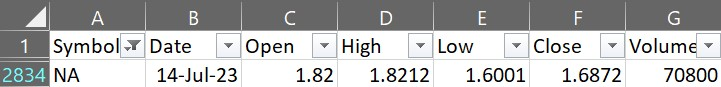

In [19]:
# Confirm the location of the symbol "NaN"
ticker_list.iloc[2832,0]

nan

In [20]:
# Replace the symbol "NaN" as "NA"
ticker_list.iloc[2832,0] = "NA"

In [21]:
# Confirm the replacement is completed
ticker_list.iloc[2832,0]

'NA'

In [22]:
# Confirm again that the replacement is completed
ticker_list[ticker_list.isnull().any(axis=1)]

,Symbol


In [23]:
ticker_list.columns = ticker_list.columns.str.lower()
ticker_list.head(3)

,symbol
0,AACG
1,AACIW
2,AADI


#### 1.4.1.2 Export data to CSV

In [6]:
ticker_list.to_csv('./Data/NASDAQ_20230714.csv', index=False)

### 1.4.2 Webscrape OHLC weekly data of the tickers

In [7]:
url = "https://twelve-data1.p.rapidapi.com/time_series"

data_frames = []  # List to store the DataFrames for each response

for symbol in ticker_list['symbol']:
    querystring = {"symbol": symbol, "interval": "1week", "outputsize": "600", "format": "json"}

    headers = {
        "X-RapidAPI-Key": "bf5f9ac5d2msh068b30f44494848p1e04c8jsnc5da0b688583",
        "X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    json_data = response.json()

    try:
        # Extract desired data from JSON response
        time_series_data = json_data['values']

        # Convert extracted data to DataFrame
        df = pd.DataFrame(time_series_data)
        
        # Add the extra columns
        df['symbol'] = symbol
        
        df['currency'] = json_data['meta']['currency']

        # Add the DataFrame to the list
        data_frames.append(df)
    except KeyError:
        print("KeyError: 'values' not found in JSON response:")
        print(json_data)

    time.sleep(1.5)  # Pause execution for 1.5 second

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(data_frames)

# Print the resulting DataFrame
combined_df.head()

KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'ABLLW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'ACAHW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'AIXI', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'ALCYU', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'ALCYW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol'

KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'FORLW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'FTAIM', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'GAMCW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 400, 'message': '**symbol** not found: GIA. Please specify it correctly according to API Documentation.', 'status': 'error', 'meta': {'symbol': 'GIA', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 400, 'message': '**symbol** not found: GODNR. Please specify it correctly according to API Documentation.', 'status': 'error', 'meta': {'symbol': 'GODNR', 'interval': '1week'

KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'SXTPW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 400, 'message': '**symbol** not found: TBMCR. Please specify it correctly according to API Documentation.', 'status': 'error', 'meta': {'symbol': 'TBMCR', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'THCPW', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 400, 'message': '**symbol** not found: TMTCR. Please specify it correctly according to API Documentation.', 'status': 'error', 'meta': {'symbol': 'TMTCR', 'interval': '1week', 'exchange': ''}}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error', 'meta': {'symbol': 'TMTCU', 'interval': '1w

,datetime,open,high,low,close,volume,symbol,currency
0,2023-07-24,1.38000,1.44000,1.31000,1.33000,29000,AACG,USD
1,2023-07-17,1.44000,1.51000,1.39000,1.39000,26400,AACG,USD
2,2023-07-10,1.35000,1.62000,1.35000,1.48000,51900,AACG,USD
3,2023-07-03,1.41000,1.50000,1.34000,1.38000,19700,AACG,USD
4,2023-06-26,1.35000,1.49000,1.35000,1.43000,31500,AACG,USD


#### 1.4.2.1 Data Dictionary

| Feature  | Type       | Description            |
|----------|------------|------------------------|
| symbol   | string     | Each stock listed on the exchange is assigned a symbol, which is used for trading, tracking, and identifying the company in financial markets |
| datetime | string     | Date which the particular stock market or exchange operates  |
| open     | float      | "Open Price": price at which a particular stock begins trading on a given trading day  |
| high     | float      | "Highest Price": peak price reached by the stock within that trading day  | 
| low      | float      | "Lowest Price": peak price reached by the stock within that trading day    | 
| close    | float      | "Close Price": last transaction or trade price of the stock before the market closes   | 
| volume   | float      | Represents the quantity of shares exchanged between buyers and sellers    |
| currency | string     | Currency which the stock is trading in the market   | 

#### 1.4.2.2 Export data to CSV

In [12]:
combined_df.to_csv('./Data/time_series_data.csv', index=False)

### 1.4.3 Webscrape profile of the tickers

In [13]:
url = "https://twelve-data1.p.rapidapi.com/profile"

data_frames = []  # List to store the DataFrames for each response

for symbol in ticker_list['symbol']:
    querystring = {"symbol": symbol, "format": "json"}

    headers = {
        "X-RapidAPI-Key": "bf5f9ac5d2msh068b30f44494848p1e04c8jsnc5da0b688583",
        "X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    json_data = response.json()

    try:
        # Define the columns to extract
        columns_to_extract = ['symbol', 'name', 'sector', 'industry', 'description', 'type', 'CEO','country']

        # Create a dictionary to store the extracted values
        extracted_data = {column: [json_data[column]] for column in columns_to_extract}

        # Convert extracted data to DataFrame
        df = pd.DataFrame(extracted_data)

        # Add the DataFrame to the list
        data_frames.append(df)
    except KeyError:
        print("KeyError: 'values' not found in JSON response:")
        print(json_data)

    time.sleep(10)  # Pause execution for 10 second

# Concatenate all DataFrames into a single DataFrame
combined2_df = pd.concat(data_frames)

# Print the resulting DataFrame
combined2_df.head()

KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' 

KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' 

,symbol,name,sector,industry,description,type,CEO,country
0,AACG,ATA Creativity Global,Consumer Defensive,Education & Training Services,"ATA Creativity Global, together with its subsidiaries, provides educational services to individu...",Depositary Receipt,Mr. Xiaofeng Ma,US
0,AACIW,Armada Acquisition Corp. I,,,,Common Stock,,US
0,AADI,"Aadi Bioscience, Inc.",Healthcare,Biotechnology,"Aadi Bioscience, Inc., a clinical-stage biopharmaceutical company, engages in developing and com...",Common Stock,Mr. Scott M. Giacobello CPA,US
0,AADR,AdvisorShares Dorsey Wright ADR ETF,,,The fund seeks to achieve the fund's investment objective by selecting primarily a portfolio of ...,ETF,,US
0,AAL,American Airlines Group Inc,Industrials,Airlines,"American Airlines Group Inc., through its subsidiaries, operates as a network air carrier. The c...",Common Stock,Mr. Robert D. Isom Jr.,US


#### 1.4.3.1 Data Dictionary

| Feature     | Type       | Description                                                                 |
|-------------|------------|-----------------------------------------------------------------------------|
| symbol      | string     | Each stock listed on the exchange is assigned a symbol, which is used for trading, tracking, and identifying the company in financial markets |
| name        | string     | Name of the company                                                         |
| sector      | string     | Sector of the company                                                       |
| industry    | string     | Industry of the company                                                     | 
| description | string     | Description of the company                                                  | 
| type        | string     | Types of securities and variables e.g. bonds, Exchange-Traded Funds (ETFs)  | 
| CEO         | string     | Chief executive officer of the company                                      |
| country     | string     | Location of the company                                                     | 

#### 1.4.3.2 Export data to CSV

In [ ]:
combined2_df.to_csv('./Data/stock_profile.csv', index=False)

### 1.4.4 Webscrape dividends of the tickers

In [9]:
url = "https://twelve-data1.p.rapidapi.com/dividends"

data_frames = []  # List to store the DataFrames for each response

for symbol in ticker_list['symbol']:
    querystring = {"symbol": symbol, "range": "full", "format": "json"}

    headers = {
        "X-RapidAPI-Key": "bf5f9ac5d2msh068b30f44494848p1e04c8jsnc5da0b688583",
        "X-RapidAPI-Host": "twelve-data1.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers, params=querystring)
    json_data = response.json()

    try:
        # Extract dividends data from JSON response
        dividends_data = json_data['dividends']

        # Create a DataFrame from the dividends data
        df = pd.DataFrame(dividends_data)

        # Add the extra columns
        df['symbol'] = symbol

        # Add the DataFrame to the list
        data_frames.append(df)
        
    except KeyError:
        print("KeyError: 'values' not found in JSON response:")
        print(json_data)

    time.sleep(20)  # Pause execution for 20 second

# Concatenate all DataFrames into a single DataFrame
combined3_df = pd.concat(data_frames)

# Print the resulting DataFrame
combined3_df.head()

KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' 

KeyError: 'values' not found in JSON response:
{'messages': 'The API is unreachable, please contact the API provider', 'info': 'Your Client (working) ---> Gateway (working) ---> API (not working)'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON response:
{'code': 404, 'message': 'Data not found', 'status': 'error'}
KeyError: 'values' not found in JSON re

,payment_date,amount,symbol
0,2018-08-27,6.000,AACG
1,2017-06-08,0.410,AACG
2,2014-06-26,0.410,AACG
3,2012-08-16,0.174,AACG
4,2011-06-28,0.430,AACG


#### 1.4.4.1 Data Dictionary

| Feature       | Type       | Description                                                                 |
|---------------|------------|-----------------------------------------------------------------------------|
| symbol        | string     | Each stock listed on the exchange is assigned a symbol, which is used for trading, tracking, and identifying the company in financial markets |
| payment_date  | string     | Date of dividend payment made                                               |
| amount        | float      | Amount of dividend                                                          |

#### 1.4.4.2 Export data to CSV

In [10]:
combined3_df.to_csv('./Data/stock_dividend.csv', index=False)

### 1.4.5 Webscrape income statements of the tickers

In [38]:
data_frames = []
for symbol in ticker_list['symbol']:
    try:
        df = yf.Ticker(symbol).income_stmt
        df_transposed = df.T
        df_transposed.insert(0, 'symbol', symbol)
        data_frames.append(df_transposed)
    except KeyError:
        print("KeyError: Data not found")

    time.sleep(1)  # Pause execution for 1 second

# Concatenate all DataFrames into a single DataFrame
combined4_df = pd.concat(data_frames)

# Print the resulting DataFrame
combined4_df.head()

,symbol,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBIT,Net Interest Income,Normalized Income,Net Income From Continuing And Discontinued Operation,Total Expenses,Total Operating Income As Reported,Diluted Average Shares,Basic Average Shares,Diluted EPS,Basic EPS,Diluted NI Availto Com Stockholders,Net Income Common Stockholders,Net Income,Minority Interests,Net Income Including Noncontrolling Interests,Net Income Discontinuous Operations,Net Income Continuous Operations,Tax Provision,Pretax Income,Other Income Expense,Special Income Charges,Gain On Sale Of Business,Write Off,Impairment Of Capital Assets,Earnings From Equity Interest,Gain On Sale Of Security,Net Non Operating Interest Income Expense,Total Other Finance Cost,Operating Income,Operating Expense,Other Operating Expenses,Provision For Doubtful Accounts,Research And Development,Selling General And Administration,Selling And Marketing Expense,General And Administrative Expense,Other Gand A,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Interest Income,Interest Income Non Operating,Salaries And Wages,Interest Expense,Preferred Stock Dividends,Other Non Operating Income Expenses,Other Special Charges,Interest Expense Non Operating,Rent Expense Supplemental,Restructuring And Mergern Acquisition,Other Taxes,Average Dilution Earnings,Gain On Sale Of Ppe,Depreciation Amortization Depletion Income Statement,Depreciation And Amortization In Income Statement,Depreciation Income Statement,Insurance And Claims,Amortization,Amortization Of Intangibles Income Statement,Otherunder Preferred Stock Dividend,Net Income From Tax Loss Carryforward,Excise Taxes,Earnings From Equity Interest Net Of Tax,Rent And Landing Fees,Securities Amortization,Net Income Extraordinary,Depletion Income Statement
2022-12-31,AACG,142731.061975,0.108618,-57900627.0,1314063.0,1314063.0,-47892909.0,22590666.0,104315856.0,-56586564.0,756886.0,-49064240.938025,-47892909.0,263407438.0,-56586564.0,31376920.0,31376920.0,-1.52,-1.52,-47892909.0,-47892909.0,-47892909.0,701322.0,-48594231.0,NaN,-48594231.0,-5921384.0,-54515615.0,1314063.0,1308627.0,1308627.0,0.0,0.0,NaN,5436.0,756886.0,-756886.0,-56586564.0,159091582.0,-16515.0,0.0,6790791.0,152317306.0,75265726.0,77051580.0,77051580.0,102505018.0,104315856.0,206820874.0,206820874.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31,AACG,1108711.604033,0.040569,-93718591.0,27329108.0,27329108.0,-33649593.0,23025480.0,97413915.0,-66389483.0,1110681.0,-59869989.395967,-33649593.0,268598948.0,-66389483.0,31374048.0,31374048.0,-1.14,-1.14,-33649593.0,-33649593.0,-33649593.0,2760524.0,-36410117.0,0.0,-36410117.0,-1539577.0,-37949694.0,27329108.0,-6000000.0,33542154.0,6000000.0,0.0,NaN,33329108.0,1110681.0,-1110681.0,-66389483.0,171185033.0,-22018.0,0.0,11801545.0,159405506.0,66149460.0,93256046.0,93256046.0,104795550.0,97413915.0,202209465.0,202209465.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,AACG,-710270.337336,0.092634,-96690477.0,-7667472.0,-7667472.0,-92198032.0,29913815.0,98521027.0,-104357949.0,1171837.0,-85240830.337336,-92198032.0,266525496.0,-107478374.0,31330018.0,31330018.0,-3.14,-3.14,-92198032.0,-92198032.0,-92198032.0,8386716.0,-100584748.0,0.0,-100584748.0,-10268836.0,-110853584.0,-7667472.0,-4846816.0,-1767800.0,1726391.0,3120425.0,NaN,-2820656.0,1171837.0,-1171837.0,-104357949.0,168004469.0,-330224.0,5904305.0,8832488.0,153597900.0,53500051.0,100097849.0,100097849.0,63646520.0,98521027.0,162167547.0,162167547.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,AACG,-1832013.30808,0.051312,-73136676.0,-35703320.0,-35703320.0,-127048595.0,17

combined4_df.info()

In [39]:
#Define a function to convert non-null cells to float
def convert_to_float(cell_value):
    try:
        return float(cell_value)
    except:
        return cell_value

In [40]:
# Convert each cell to float where possible
combined4_df = combined4_df.applymap(convert_to_float)

combined4_df.info()

#### 1.4.5.1 Data Dictionary

| Feature                                                     |Type   |
|-------------------------------------------------------------|-------|
| symbol                                                      |string |Each stock listed on the exchange is assigned a symbol, which is used for trading, tracking, and identifying the company in financial markets|
| Tax Effect Of Unusual Items                                 |float  |
| Tax Rate For Calcs                                          |float  |
| Normalized EBITDA                                           |float  |
| Total Unusual Items                                         |float  |
| Total Unusual Items Excluding Goodwill                      |float  |
| Net Income From Continuing Operation Net Minority Interest  |float  |
| Reconciled Depreciation                                     |float  |
| Reconciled Cost Of Revenue                                  |float  |
| EBIT                                                        |float  |
| Net Interest Income                                         |float  |
| Normalized Income                                           |float  |
| Net Income From Continuing And Discontinued Operation       |float  |
| Total Expenses                                              |float  |
| Total Operating Income As Reported                          |float  |
| Diluted Average Shares                                      |float  |
| Basic Average Shares                                        |float  |
| Diluted EPS                                                 |float  |
| Basic EPS                                                   |float  |
| Diluted NI Availto Com Stockholders                         |float  |
| Net Income Common Stockholders                              |float  |
| Net Income                                                  |float  |
| Minority Interests                                          |float  |
| Net Income Including Noncontrolling Interests               |float  |
| Net Income Discontinuous Operations                         |float  |
| Net Income Continuous Operations                            |float  |
| Tax Provision                                               |float  |
| Pretax Income                                               |float  |
| Other Income Expense                                        |float  |
| Special Income Charges                                      |float  |
| Gain On Sale Of Business                                    |float  |
| Write Off                                                   |float  |
| Impairment Of Capital Assets                                |float  |
| Earnings From Equity Interest                               |float  |
| Gain On Sale Of Security                                    |float  |
| Net Non Operating Interest Income Expense                   |float  |
| Total Other Finance Cost                                    |float  |
| Operating Income                                            |float  |
| Operating Expense                                           |float  |
| Other Operating Expenses                                    |float  |
| Provision For Doubtful Accounts                             |float  |
| Research And Development                                    |float  |
| Selling General And Administration                          |float  |
| Selling And Marketing Expense                               |float  |
| General And Administrative Expense                          |float  |
| Other Gand A                                                |float  |
| Gross Profit                                                |float  |
| Cost Of Revenue                                             |float  |
| Total Revenue                                               |float  |
| Operating Revenue                                           |float  |
| Interest Income                                             |float  |
| Interest Income Non Operating                               |float  |
| Salaries And Wages                                          |float  |
| Interest Expense                                            |float  |
| Preferred Stock Dividends                                   |float  |
| Other Non Operating Income Expenses                         |float  |
| Other Special Charges                                       |float  |
| Interest Expense Non Operating                              |float  |
| Rent Expense Supplemental                                   |float  |
| Restructuring And Mergern Acquisition                       |float  |
| Other Taxes                                                 |float  |
| Average Dilution Earnings                                   |float  |
| Gain On Sale Of Ppe                                         |float  |
| Depreciation Amortization Depletion Income Statement        |float  |
| Depreciation And Amortization In Income Statement           |float  |
| Depreciation Income Statement                               |float  |
| Insurance And Claims                                        |float  |
| Amortization                                                |float  |
| Amortization Of Intangibles Income Statement                |float  |
| Otherunder Preferred Stock Dividend                         |float  |
| Net Income From Tax Loss Carryforward                       |float  |
| Excise Taxes                                                |float  |
| Earnings From Equity Interest Net Of Tax                    |float  |
| Rent And Landing Fees                                       |float  |
| Securities Amortization                                     |float  |
| Net Income Extraordinary                                    |float  |
| Depletion Income Statement                                  |float  |

#### 1.4.5.2 Export data to CSV

In [41]:
combined4_df.to_csv('./Data/stock_income_statement.csv', index=True)

### 1.4.6 Webscrape balance sheet of the tickers

In [42]:
data_frames = []
for symbol in ticker_list['symbol']:
    try:
        df = yf.Ticker(symbol).balance_sheet
        df_transposed = df.T
        df_transposed.insert(0, 'symbol', symbol)
        data_frames.append(df_transposed)
    except KeyError:
        print("KeyError: Data not found")

    time.sleep(1)  # Pause execution for 1 second

# Concatenate all DataFrames into a single DataFrame
combined5_df = pd.concat(data_frames)

# Print the resulting DataFrame
combined5_df.head()

,symbol,Treasury Shares Number,Ordinary Shares Number,Share Issued,Total Debt,Tangible Book Value,Invested Capital,Working Capital,Net Tangible Assets,Capital Lease Obligations,Common Stock Equity,Total Capitalization,Total Equity Gross Minority Interest,Minority Interest,Stockholders Equity,Gains Losses Not Affecting Retained Earnings,Other Equity Adjustments,Treasury Stock,Retained Earnings,Additional Paid In Capital,Capital Stock,Common Stock,Total Liabilities Net Minority Interest,Total Non Current Liabilities Net Minority Interest,Other Non Current Liabilities,Preferred Securities Outside Stock Equity,Non Current Deferred Liabilities,Non Current Deferred Taxes Liabilities,Long Term Debt And Capital Lease Obligation,Long Term Capital Lease Obligation,Current Liabilities,Other Current Liabilities,Current Deferred Liabilities,Current Deferred Revenue,Current Debt And Capital Lease Obligation,Current Capital Lease Obligation,Current Debt,Other Current Borrowings,Payables And Accrued Expenses,Current Accrued Expenses,Payables,Other Payable,Total Tax Payable,Income Tax Payable,Total Assets,Total Non Current Assets,Other Non Current Assets,Non Current Deferred Assets,Non Current Deferred Taxes Assets,Investments And Advances,Goodwill And Other Intangible Assets,Other Intangible Assets,Goodwill,Net PPE,Accumulated Depreciation,Gross PPE,Leases,Other Properties,Machinery Furniture Equipment,Buildings And Improvements,Properties,Current Assets,Other Current Assets,Prepaid Assets,Receivables,Other Receivables,Duefrom Related Parties Current,Taxes Receivable,Loans Receivable,Accounts Receivable,Cash Cash Equivalents And Short Term Investments,Cash And Cash Equivalents,Net Debt,Preferred Stock,Current Notes Payable,Accounts Payable,Non Current Prepaid Assets,Cash Financial,Preferred Stock Equity,Dueto Related Parties Non Current,Tradeand Other Payables Non Current,Long Term Debt,Dueto Related Parties Current,Construction In Progress,Inventory,Finished Goods,Work In Process,Raw Materials,Other Short Term Investments,Employee Benefits,Non Current Pension And Other Postretirement Benefit Plans,Non Current Deferred Revenue,Restricted Cash,Allowance For Doubtful Accounts Receivable,Gross Accounts Receivable,Preferred Shares Number,Other Equity Interest,Line Of Credit,Long Term Equity Investment,Investments In Other Ventures Under Equity Method,Pensionand Other Post Retirement Benefit Plans Current,Interest Payable,Land And Improvements,Notes Receivable,Non Current Note Receivables,Inventories Adjustments Allowances,Commercial Paper,Other Investments,Investmentin Financial Assets,Available For Sale Securities,Cash Equivalents,Held To Maturity Securities,Foreign Currency Translation Adjustments,Derivative Product Liabilities,Investmentsin Subsidiariesat Cost,Hedging Assets Current,Current Deferred Taxes Liabilities,Current Provisions,Non Current Accounts Receivable,Receivables Adjustments Allowances,Non Current Accrued Expenses,Duefrom Related Parties Non Current,Accrued Interest Receivable,Current Deferred Assets,Financial Assets,Assets Held For Sale Current,Other Inventories,Investmentsin Associatesat Cost,Liabilities Heldfor Sale Non Current,Dividends Payable,Financial Assets Designatedas Fair Value Through Profitor Loss Total,Long Term Provisions,Investment Properties,Total Partnership Capital,Limited Partnership Capital,Defined Pension Benefit,Trading Securities,Investmentsin Joint Venturesat Cost,Current Deferred Taxes Assets,Restricted Common Stock,Unrealized Gain Loss,Minimum Pension Liabilities,General Partnership Capital,Fixed Assets Revaluation Reserve
2022-12-31,AACG,585358.0,63244340.0,63829698.0,36449192.0,-129309603.0,143099333.0,-227279991.0,-129309603.0,36449192.0,143099333.0,143099333.0,143514190.0,414857.0,143099333.0,-37003085.0,-37003085.0,8626894.0,-358048927.0,542058092.0,4720147.0,4720147.0,330950579.0,38408066.0,NaN,NaN,18879303.0,18879303.0,19528763.0,19528763.0,292542513.0,29437640.0,219717574.0,219717574.0,1692042

combined5_df.info(verbose=True)

In [43]:
# Convert each cell to float where possible
combined5_df = combined5_df.applymap(convert_to_float)

combined5_df.info(verbose=True)

#### 1.4.6.1 Data Dictionary

| Feature                                                              	| Type   	|
|-----------------------------------------------------------------------|-----------|
| symbol                                                               	| string 	|
| Treasury Shares Number                                               	| float  	|
| Ordinary Shares Number                                               	| float  	|
| Share Issued                                                         	| float  	|
| Total Debt                                                           	| float  	|
| Tangible Book Value                                                  	| float  	|
| Invested Capital                                                     	| float  	|
| Working Capital                                                      	| float  	|
| Net Tangible Assets                                                  	| float  	|
| Capital Lease Obligations                                            	| float  	|
| Common Stock Equity                                                  	| float  	|
| Total Capitalization                                                 	| float  	|
| Total Equity Gross Minority Interest                                 	| float  	|
| Minority Interest                                                    	| float  	|
| Stockholders Equity                                                  	| float  	|
| Gains Losses Not Affecting Retained Earnings                         	| float  	|
| Other Equity Adjustments                                             	| float  	|
| Treasury Stock                                                       	| float  	|
| Retained Earnings                                                    	| float  	|
| Additional Paid In Capital                                           	| float  	|
| Capital Stock                                                        	| float  	|
| Common Stock                                                         	| float  	|
| Total Liabilities Net Minority Interest                              	| float  	|
| Total Non Current Liabilities Net Minority Interest                  	| float  	|
| Other Non Current Liabilities                                        	| float  	|
| Preferred Securities Outside Stock Equity                            	| float  	|
| Non Current Deferred Liabilities                                     	| float  	|
| Non Current Deferred Taxes Liabilities                               	| float  	|
| Long Term Debt And Capital Lease Obligation                          	| float  	|
| Long Term Capital Lease Obligation                                   	| float  	|
| Current Liabilities                                                  	| float  	|
| Other Current Liabilities                                            	| float  	|
| Current Deferred Liabilities                                         	| float  	|
| Current Deferred Revenue                                             	| float  	|
| Current Debt And Capital Lease Obligation                            	| float  	|
| Current Capital Lease Obligation                                     	| float  	|
| Current Debt                                                         	| float  	|
| Other Current Borrowings                                             	| float  	|
| Payables And Accrued Expenses                                        	| float  	|
| Current Accrued Expenses                                             	| float  	|
| Payables                                                             	| float  	|
| Other Payable                                                        	| float  	|
| Total Tax Payable                                                    	| float  	|
| Income Tax Payable                                                   	| float  	|
| Total Assets                                                         	| float  	|
| Total Non Current Assets                                             	| float  	|
| Other Non Current Assets                                             	| float  	|
| Non Current Deferred Assets                                          	| float  	|
| Non Current Deferred Taxes Assets                                    	| float  	|
| Investments And Advances                                             	| float  	|
| Goodwill And Other Intangible Assets                                 	| float  	|
| Other Intangible Assets                                              	| float  	|
| Goodwill                                                             	| float  	|
| Net PPE                                                              	| float  	|
| Accumulated Depreciation                                             	| float  	|
| Gross PPE                                                            	| float  	|
| Leases                                                               	| float  	|
| Other Properties                                                     	| float  	|
| Machinery Furniture Equipment                                        	| float  	|
| Buildings And Improvements                                           	| float  	|
| Properties                                                           	| float  	|
| Current Assets                                                       	| float  	|
| Other Current Assets                                                 	| float  	|
| Prepaid Assets                                                       	| float  	|
| Receivables                                                          	| float  	|
| Other Receivables                                                    	| float  	|
| Duefrom Related Parties Current                                      	| float  	|
| Taxes Receivable                                                     	| float  	|
| Loans Receivable                                                     	| float  	|
| Accounts Receivable                                                  	| float  	|
| Cash Cash Equivalents And Short Term Investments                     	| float  	|
| Cash And Cash Equivalents                                            	| float  	|
| Net Debt                                                             	| float  	|
| Preferred Stock                                                      	| float  	|
| Current Notes Payable                                                	| float  	|
| Accounts Payable                                                     	| float  	|
| Non Current Prepaid Assets                                           	| float  	|
| Cash Financial                                                       	| float  	|
| Preferred Stock Equity                                               	| float  	|
| Dueto Related Parties Non Current                                    	| float  	|
| Tradeand Other Payables Non Current                                  	| float  	|
| Long Term Debt                                                       	| float  	|
| Dueto Related Parties Current                                        	| float  	|
| Construction In Progress                                             	| float  	|
| Inventory                                                            	| float  	|
| Finished Goods                                                       	| float  	|
| Work In Process                                                      	| float  	|
| Raw Materials                                                        	| float  	|
| Other Short Term Investments                                         	| float  	|
| Employee Benefits                                                    	| float  	|
| Non Current Pension And Other Postretirement Benefit Plans           	| float  	|
| Non Current Deferred Revenue                                         	| float  	|
| Restricted Cash                                                      	| float  	|
| Allowance For Doubtful Accounts Receivable                           	| float  	|
| Gross Accounts Receivable                                            	| float  	|
| Preferred Shares Number                                              	| float  	|
| Other Equity Interest                                                	| float  	|
| Line Of Credit                                                       	| float  	|
| Long Term Equity Investment                                          	| float  	|
| Investments In Other Ventures Under Equity Method                    	| float  	|
| Pensionand Other Post Retirement Benefit Plans Current               	| float  	|
| Interest Payable                                                     	| float  	|
| Land And Improvements                                                	| float  	|
| Notes Receivable                                                     	| float  	|
| Non Current Note Receivables                                         	| float  	|
| Inventories Adjustments Allowances                                   	| float  	|
| Commercial Paper                                                     	| float  	|
| Other Investments                                                    	| float  	|
| Investmentin Financial Assets                                        	| float  	|
| Available For Sale Securities                                        	| float  	|
| Cash Equivalents                                                     	| float  	|
| Held To Maturity Securities                                          	| float  	|
| Foreign Currency Translation Adjustments                             	| float  	|
| Derivative Product Liabilities                                       	| float  	|
| Investmentsin Subsidiariesat Cost                                    	| float  	|
| Hedging Assets Current                                               	| float  	|
| Current Deferred Taxes Liabilities                                   	| float  	|
| Current Provisions                                                   	| float  	|
| Non Current Accounts Receivable                                      	| float  	|
| Receivables Adjustments Allowances                                   	| float  	|
| Non Current Accrued Expenses                                         	| float  	|
| Duefrom Related Parties Non Current                                  	| float  	|
| Accrued Interest Receivable                                          	| float  	|
| Current Deferred Assets                                              	| float  	|
| Financial Assets                                                     	| float  	|
| Assets Held For Sale Current                                         	| float  	|
| Other Inventories                                                    	| float  	|
| Investmentsin Associatesat Cost                                      	| float  	|
| Liabilities Heldfor Sale Non Current                                 	| float  	|
| Dividends Payable                                                    	| float  	|
| Financial Assets Designatedas Fair Value Through Profitor Loss Total 	| float  	|
| Long Term Provisions                                                 	| float  	|
| Investment Properties                                                	| float  	|
| Total Partnership Capital                                            	| float  	|
| Limited Partnership Capital                                          	| float  	|
| Defined Pension Benefit                                              	| float  	|
| Trading Securities                                                   	| float  	|
| Investmentsin Joint Venturesat Cost                                  	| float  	|
| Current Deferred Taxes Assets                                        	| float  	|
| Restricted Common Stock                                              	| float  	|
| Unrealized Gain Loss                                                 	| float  	|
| Minimum Pension Liabilities                                          	| float  	|
| General Partnership Capital                                          	| float  	|
| Fixed Assets Revaluation Reserve                                     	| float  	|

#### 1.4.6.2 Export data to CSV

In [44]:
combined5_df.to_csv('./Data/stock_balance_sheet.csv', index=True)

### 1.4.7 Webscrape cashflow of the tickers

In [45]:
data_frames = []
for symbol in ticker_list['symbol']:
    try:
        df = yf.Ticker(symbol).cashflow
        df_transposed = df.T
        df_transposed.insert(0, 'symbol', symbol)
        data_frames.append(df_transposed)
    except KeyError:
        print("KeyError: Data not found")

    time.sleep(1)  # Pause execution for 1 second

# Concatenate all DataFrames into a single DataFrame
combined6_df = pd.concat(data_frames)

# Print the resulting DataFrame
combined6_df.head()

,symbol,Free Cash Flow,Repurchase Of Capital Stock,Repayment Of Debt,Issuance Of Debt,Issuance Of Capital Stock,Capital Expenditure,Interest Paid Supplemental Data,Income Tax Paid Supplemental Data,End Cash Position,Beginning Cash Position,Effect Of Exchange Rate Changes,Changes In Cash,Financing Cash Flow,Cash Flow From Continuing Financing Activities,Net Other Financing Charges,Proceeds From Stock Option Exercised,Cash Dividends Paid,Common Stock Dividend Paid,Net Common Stock Issuance,Common Stock Payments,Common Stock Issuance,Net Issuance Payments Of Debt,Net Short Term Debt Issuance,Short Term Debt Payments,Short Term Debt Issuance,Net Long Term Debt Issuance,Long Term Debt Payments,Investing Cash Flow,Cash From Discontinued Investing Activities,Cash Flow From Continuing Investing Activities,Net Investment Purchase And Sale,Purchase Of Investment,Net Business Purchase And Sale,Sale Of Business,Purchase Of Business,Net Intangibles Purchase And Sale,Purchase Of Intangibles,Net PPE Purchase And Sale,Sale Of PPE,Purchase Of PPE,Operating Cash Flow,Cash Flow From Continuing Operating Activities,Change In Working Capital,Change In Other Working Capital,Change In Other Current Assets,Change In Payables And Accrued Expense,Change In Accrued Expense,Change In Payable,Change In Tax Payable,Change In Income Tax Payable,Change In Prepaid Assets,Change In Receivables,Changes In Account Receivables,Stock Based Compensation,Unrealized Gain Loss On Investment Securities,Provisionand Write Offof Assets,Asset Impairment Charge,Deferred Tax,Deferred Income Tax,Depreciation Amortization Depletion,Depreciation And Amortization,Operating Gains Losses,Earnings Losses From Equity Investments,Net Foreign Currency Exchange Gain Loss,Gain Loss On Sale Of PPE,Gain Loss On Sale Of Business,Net Income From Continuing Operations,Long Term Debt Issuance,Net Other Investing Changes,Change In Account Payable,Other Non Cash Items,Sale Of Investment,Change In Other Current Liabilities,Change In Inventory,Amortization Of Securities,Capital Expenditure Reported,Pension And Employee Benefit Expense,Preferred Stock Dividend Paid,Dividend Received Cfo,Gain Loss On Investment Securities,Depreciation,Net Investment Properties Purchase And Sale,Sale Of Investment Properties,Sale Of Intangibles,Amortization Cash Flow,Amortization Of Intangibles,Net Preferred Stock Issuance,Preferred Stock Payments,Preferred Stock Issuance,Interest Paid Cff,Interest Received Cfi,Taxes Refund Paid,Change In Interest Payable,Cash From Discontinued Financing Activities,Dividends Received Cfi,Cash From Discontinued Operating Activities,Other Cash Adjustment Outside Changein Cash,Purchase Of Investment Properties,Interest Received Cfo,Interest Paid Cfo,Cash Flow From Discontinued Operation,Cash Flowsfromusedin Operating Activities Direct,Taxes Refund Paid Direct,Interest Received Direct,Interest Paid Direct,Classesof Cash Payments,Other Cash Paymentsfrom Operating Activities,Paymentsto Suppliersfor Goodsand Services,Classesof Cash Receiptsfrom Operating Activities,Other Cash Receiptsfrom Operating Activities,Receiptsfrom Government Grants,Receiptsfrom Customers,Depletion,Dividend Paid Cfo,Excess Tax Benefit From Stock Based Compensation,Dividends Received Direct,Paymentson Behalfof Employees,Change In Dividend Payable,Other Cash Adjustment Inside Changein Cash,Dividends Paid Direct
2022-12-31,AACG,-16232225.0,0.0,0.0,0.0,0.0,-1618338.0,0.0,28316.0,54980199.0,71339361.0,556616.0,-16915778.0,188212.0,188212.0,-30731.0,218943.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,-2490103.0,NaN,-2490103.0,NaN,NaN,-877775.0,0.0,-877775.0,NaN,NaN,-1612328.0,6010.0,-1618338.0,-14613887.0,-14613887.0,17291938.0,18874126.0,-1833631.0,10876507.0,10884454.0,-7947.0,-7947.0,-7947.0,-5711215.0,-4913849.0,-4913849.0,1459755.0,NaN,0.0,0.0,-6052019.0,-6052019.0,22590666.0,22590666.0,-1309996.0,NaN,323.0,-1692.0,-1308627.0,-48594231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

combined6_df.info(verbose=True)

In [46]:
# Convert each cell to float where possible
combined6_df = combined6_df.applymap(convert_to_float)

combined6_df.info(verbose=True)

#### 1.4.7.1 Data Dictionary

| Feature                                          	| Type   	|
|---------------------------------------------------|-----------|
| symbol                                           	| string 	|
| Free Cash Flow                                   	| float  	|
| Repurchase Of Capital Stock                      	| float  	|
| Repayment Of Debt                                	| float  	|
| Issuance Of Debt                                 	| float  	|
| Issuance Of Capital Stock                        	| float  	|
| Capital Expenditure                              	| float  	|
| Interest Paid Supplemental Data                  	| float  	|
| Income Tax Paid Supplemental Data                	| float  	|
| End Cash Position                                	| float  	|
| Beginning Cash Position                          	| float  	|
| Effect Of Exchange Rate Changes                  	| float  	|
| Changes In Cash                                  	| float  	|
| Financing Cash Flow                              	| float  	|
| Cash Flow From Continuing Financing Activities   	| float  	|
| Net Other Financing Charges                      	| float  	|
| Proceeds From Stock Option Exercised             	| float  	|
| Cash Dividends Paid                              	| float  	|
| Common Stock Dividend Paid                       	| float  	|
| Net Common Stock Issuance                        	| float  	|
| Common Stock Payments                            	| float  	|
| Common Stock Issuance                            	| float  	|
| Net Issuance Payments Of Debt                    	| float  	|
| Net Short Term Debt Issuance                     	| float  	|
| Short Term Debt Payments                         	| float  	|
| Short Term Debt Issuance                         	| float  	|
| Net Long Term Debt Issuance                      	| float  	|
| Long Term Debt Payments                          	| float  	|
| Investing Cash Flow                              	| float  	|
| Cash From Discontinued Investing Activities      	| float  	|
| Cash Flow From Continuing Investing Activities   	| float  	|
| Net Investment Purchase And Sale                 	| float  	|
| Purchase Of Investment                           	| float  	|
| Net Business Purchase And Sale                   	| float  	|
| Sale Of Business                                 	| float  	|
| Purchase Of Business                             	| float  	|
| Net Intangibles Purchase And Sale                	| float  	|
| Purchase Of Intangibles                          	| float  	|
| Net PPE Purchase And Sale                        	| float  	|
| Sale Of PPE                                      	| float  	|
| Purchase Of PPE                                  	| float  	|
| Operating Cash Flow                              	| float  	|
| Cash Flow From Continuing Operating Activities   	| float  	|
| Change In Working Capital                        	| float  	|
| Change In Other Working Capital                  	| float  	|
| Change In Other Current Assets                   	| float  	|
| Change In Payables And Accrued Expense           	| float  	|
| Change In Accrued Expense                        	| float  	|
| Change In Payable                                	| float  	|
| Change In Tax Payable                            	| float  	|
| Change In Income Tax Payable                     	| float  	|
| Change In Prepaid Assets                         	| float  	|
| Change In Receivables                            	| float  	|
| Changes In Account Receivables                   	| float  	|
| Stock Based Compensation                         	| float  	|
| Unrealized Gain Loss On Investment Securities    	| float  	|
| Provisionand Write Offof Assets                  	| float  	|
| Asset Impairment Charge                          	| float  	|
| Deferred Tax                                     	| float  	|
| Deferred Income Tax                              	| float  	|
| Depreciation Amortization Depletion              	| float  	|
| Depreciation And Amortization                    	| float  	|
| Operating Gains Losses                           	| float  	|
| Earnings Losses From Equity Investments          	| float  	|
| Net Foreign Currency Exchange Gain Loss          	| float  	|
| Gain Loss On Sale Of PPE                         	| float  	|
| Gain Loss On Sale Of Business                    	| float  	|
| Net Income From Continuing Operations            	| float  	|
| Long Term Debt Issuance                          	| float  	|
| Net Other Investing Changes                      	| float  	|
| Change In Account Payable                        	| float  	|
| Other Non Cash Items                             	| float  	|
| Sale Of Investment                               	| float  	|
| Change In Other Current Liabilities              	| float  	|
| Change In Inventory                              	| float  	|
| Amortization Of Securities                       	| float  	|
| Capital Expenditure Reported                     	| float  	|
| Pension And Employee Benefit Expense             	| float  	|
| Preferred Stock Dividend Paid                    	| float  	|
| Dividend Received Cfo                            	| float  	|
| Gain Loss On Investment Securities               	| float  	|
| Depreciation                                     	| float  	|
| Net Investment Properties Purchase And Sale      	| float  	|
| Sale Of Investment Properties                    	| float  	|
| Sale Of Intangibles                              	| float  	|
| Amortization Cash Flow                           	| float  	|
| Amortization Of Intangibles                      	| float  	|
| Net Preferred Stock Issuance                     	| float  	|
| Preferred Stock Payments                         	| float  	|
| Preferred Stock Issuance                         	| float  	|
| Interest Paid Cff                                	| float  	|
| Interest Received Cfi                            	| float  	|
| Taxes Refund Paid                                	| float  	|
| Change In Interest Payable                       	| float  	|
| Cash From Discontinued Financing Activities      	| float  	|
| Dividends Received Cfi                           	| float  	|
| Cash From Discontinued Operating Activities      	| float  	|
| Other Cash Adjustment Outside Changein Cash      	| float  	|
| Purchase Of Investment Properties                	| float  	|
| Interest Received Cfo                            	| float  	|
| Interest Paid Cfo                                	| float  	|
| Cash Flow From Discontinued Operation            	| float  	|
| Cash Flowsfromusedin Operating Activities Direct 	| float  	|
| Taxes Refund Paid Direct                         	| float  	|
| Interest Received Direct                         	| float  	|
| Interest Paid Direct                             	| float  	|
| Classesof Cash Payments                          	| float  	|
| Other Cash Paymentsfrom Operating Activities     	| float  	|
| Paymentsto Suppliersfor Goodsand Services        	| float  	|
| Classesof Cash Receiptsfrom Operating Activities 	| float  	|
| Other Cash Receiptsfrom Operating Activities     	| float  	|
| Receiptsfrom Government Grants                   	| float  	|
| Receiptsfrom Customers                           	| float  	|
| Depletion                                        	| float  	|
| Dividend Paid Cfo                                	| float  	|
| Excess Tax Benefit From Stock Based Compensation 	| float  	|
| Dividends Received Direct                        	| float  	|
| Paymentson Behalfof Employees                    	| float  	|
| Change In Dividend Payable                       	| float  	|
| Other Cash Adjustment Inside Changein Cash       	| float  	|
| Dividends Paid Direct                            	| float  	|

#### 1.4.7.2 Export data to CSV

In [47]:
combined6_df.to_csv('./Data/stock_cashflow.csv', index=True)

In [48]:
combined6_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14278 entries, 2022-12-31 to 2019-12-31
Columns: 121 entries, symbol to Dividends Paid Direct
dtypes: float64(120), object(1)
memory usage: 13.3+ MB
